1. Data Loading & Preprocessing

   Tasks:

    Load dataset
    Check for missing values
    Normalize spectral data using Min-Max Scaling

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load dataset
file_path = "/content/drive/MyDrive/TASK-ML-INTERN.csv"  # Update path if needed
df = pd.read_csv(file_path)

# Check for missing values
print("Missing values:", df.isnull().sum().sum())

# Select spectral columns (excluding ID & target)
spectral_columns = df.columns[1:-1]

# Apply Min-Max Scaling
scaler = MinMaxScaler()
df[spectral_columns] = scaler.fit_transform(df[spectral_columns])

# Display processed data
print(df.head())


Missing values: 0
           hsi_id         0         1         2         3         4         5  \
0  imagoai_corn_0  0.428384  0.432294  0.510485  0.361585  0.411656  0.365379   
1  imagoai_corn_1  0.426816  0.458322  0.484244  0.453758  0.466945  0.478181   
2  imagoai_corn_2  0.317584  0.323124  0.363833  0.365593  0.299035  0.292418   
3  imagoai_corn_3  0.643212  0.757663  0.731006  0.705884  0.766564  0.804758   
4  imagoai_corn_4  0.702433  0.817355  0.756362  0.818619  0.777502  0.764411   

          6         7         8  ...       439       440       441       442  \
0  0.382911  0.305546  0.382076  ...  0.390543  0.372789  0.411477  0.372650   
1  0.467686  0.401405  0.506341  ...  0.321045  0.315913  0.377114  0.346713   
2  0.294413  0.246585  0.314003  ...  0.318514  0.237159  0.275166  0.291190   
3  0.809852  0.703279  0.683790  ...  0.476533  0.410269  0.468494  0.441426   
4  0.809995  0.764764  0.730135  ...  0.549142  0.529060  0.533219  0.534680   

        443   

2. Data Visualization

   Tasks:

    Line Plot: Shows average spectral reflectance per wavelength.
    Heatmap: Compares spectral data across samples.

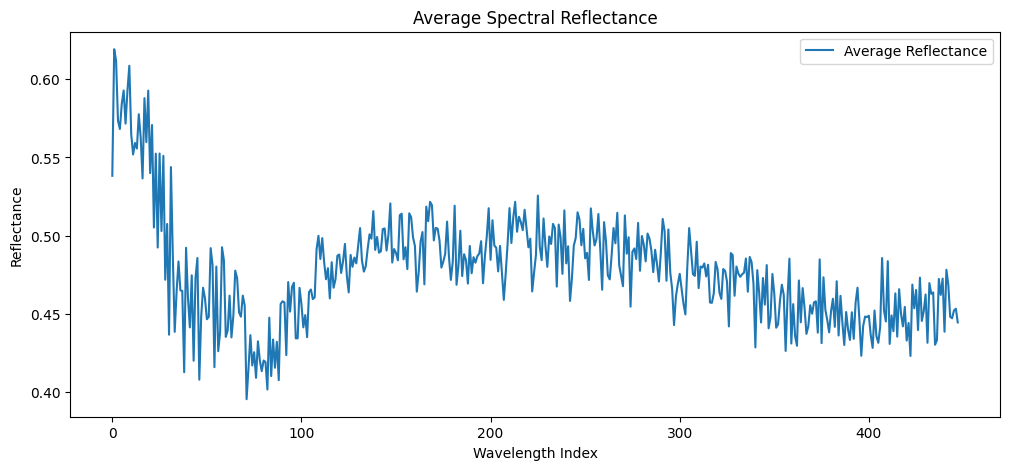

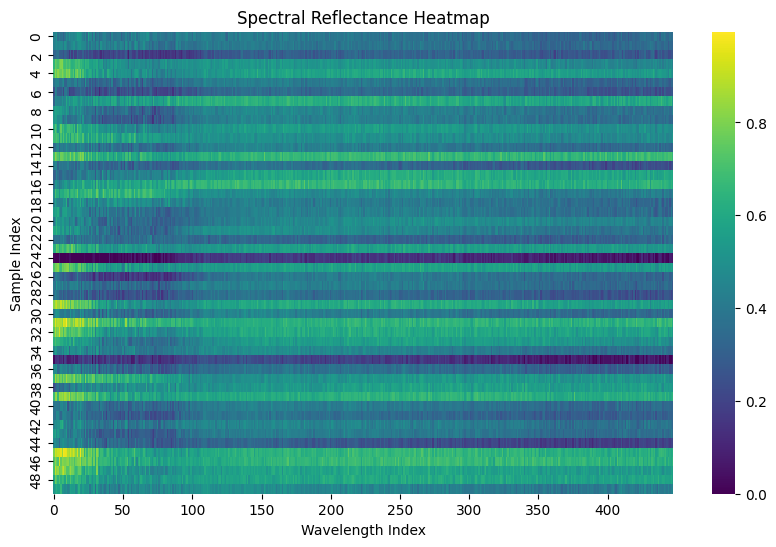

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Line Plot: Average spectral reflectance
plt.figure(figsize=(12, 5))
plt.plot(np.arange(len(spectral_columns)), df[spectral_columns].mean(), label="Average Reflectance")
plt.xlabel("Wavelength Index")
plt.ylabel("Reflectance")
plt.title("Average Spectral Reflectance")
plt.legend()
plt.show()

# Heatmap: Sample-wise spectral visualization
plt.figure(figsize=(10, 6))
sns.heatmap(df[spectral_columns].iloc[:50], cmap="viridis", xticklabels=50)
plt.xlabel("Wavelength Index")
plt.ylabel("Sample Index")
plt.title("Spectral Reflectance Heatmap")
plt.show()


3. Dimensionality Reduction (PCA & t-SNE)

  Tasks:

    PCA: Reduces dimensions and plots explained variance.
    t-SNE: Clusters high-dimensional data into 2D.

Explained Variance by PCA: [0.8582386  0.06683037]


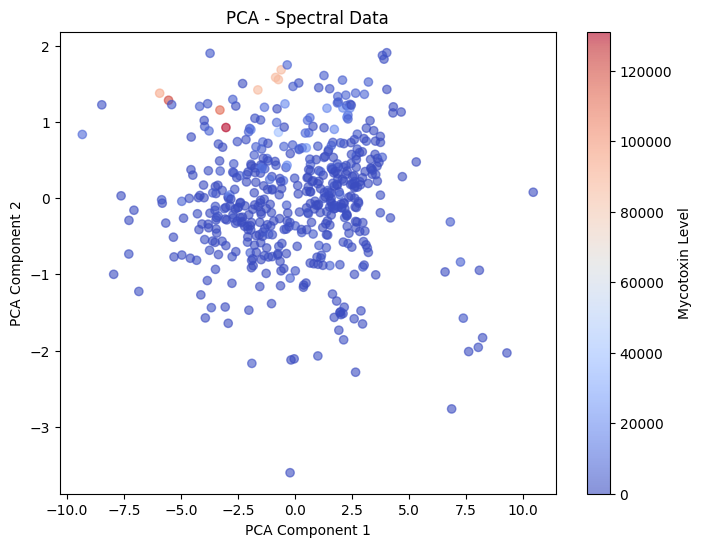

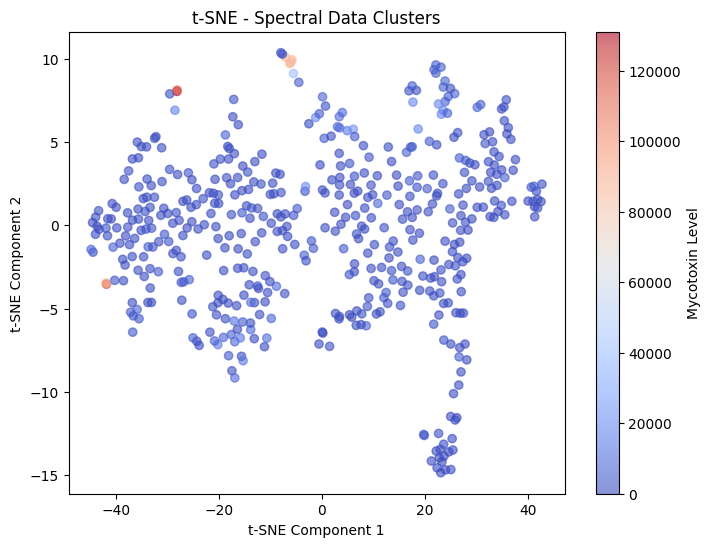

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# PCA: Reduce to 2 components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df[spectral_columns])

# Explained variance
print("Explained Variance by PCA:", pca.explained_variance_ratio_)

# Scatter plot for PCA
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=df["vomitoxin_ppb"], cmap="coolwarm", alpha=0.6)
plt.colorbar(label="Mycotoxin Level")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA - Spectral Data")
plt.show()

# t-SNE: Visualize clusters
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(df[spectral_columns])

plt.figure(figsize=(8, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=df["vomitoxin_ppb"], cmap="coolwarm", alpha=0.6)
plt.colorbar(label="Mycotoxin Level")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE - Spectral Data Clusters")
plt.show()


4. Model Training


    Split dataset into train (80%) and test (20%)
    Train a Random Forest Regressor
    Tune hyperparameters with GridSearchCV

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Features and target variable
X = df[spectral_columns]
y = df["vomitoxin_ppb"]

# Split dataset (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Hyperparameter tuning
param_grid = {"n_estimators": [50, 100, 200], "max_depth": [10, 20, None]}
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring="neg_mean_absolute_error")
grid_search.fit(X_train, y_train)

# Best model parameters
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'max_depth': 20, 'n_estimators': 100}


5. Model Evaluation

   Tasks:

    Compute regression metrics (MAE, RMSE, R² Score)
    Plot actual vs. predicted values

MAE: 3782.45, RMSE: 11501.16, R² Score: 0.53


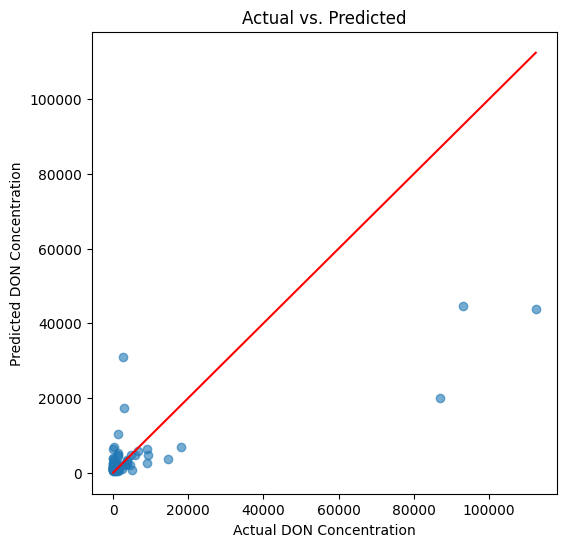

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predictions
y_pred = grid_search.best_estimator_.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R² Score: {r2:.2f}")

# Scatter plot: Actual vs Predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red")  # Reference line
plt.xlabel("Actual DON Concentration")
plt.ylabel("Predicted DON Concentration")
plt.title("Actual vs. Predicted")
plt.show()


6. Bonus: Deep Learning (Optional)

Tasks:

    Train a Neural Network (MLP) using TensorFlow

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 217419136.0000 - mae: 3711.8940 - val_loss: 298491808.0000 - val_mae: 4364.5107
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 123938424.0000 - mae: 2861.0701 - val_loss: 296465440.0000 - val_mae: 4266.0215
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 96381632.0000 - mae: 2762.0557 - val_loss: 292576512.0000 - val_mae: 4447.2964
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 127655192.0000 - mae: 2907.9453 - val_loss: 289455552.0000 - val_mae: 5002.4683
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 97010776.0000 - mae: 3156.1885 - val_loss: 288581056.0000 - val_mae: 5269.3613
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 126195000.0000 - mae: 3704.8137 - val_loss: 288341248.0000 - val_mae: 5303.2114
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 108954856.0000 - mae: 3592.4922 - val_loss: 288343968.0000 - val_mae: 5217.3027
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/s

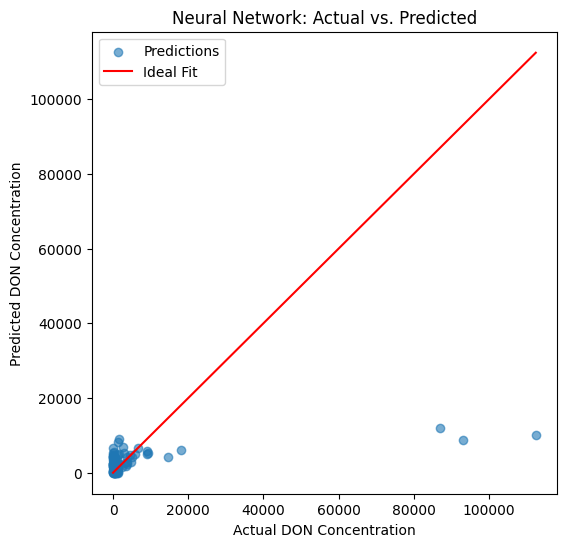

In [ ]:
import tensorflow as tf
from tensorflow import keras

# Define neural network model
model = keras.Sequential([
    keras.layers.Dense(256, activation="relu", input_shape=(X_train.shape[1],)),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(1)  # Output layer for regression
])

# Compile model
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Evaluate model
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {test_mae:.2f}")

# Predictions
y_pred_nn = model.predict(X_test).flatten()

# Scatter plot: Actual vs Predicted (Neural Network)
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_nn, alpha=0.6, label="Predictions")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", label="Ideal Fit")
plt.xlabel("Actual DON Concentration")
plt.ylabel("Predicted DON Concentration")
plt.title("Neural Network: Actual vs. Predicted")
plt.legend()
plt.show()
